In [1]:
# !unzip '/content/drive/My Drive/Colab Notebooks/cotton_disease/data.zip' -d '/content/drive/My Drive/Colab Notebooks/cotton_disease/'

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

In [5]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/'
training_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/train/'
validation_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/val/'
test_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/test/'
model_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/inception_model.h5'

IMAGE_SIZE = [224, 224,3]
EPOCHS = 30
TARGET_SIZE = (224,224)
BATCH_SIZE = 16

In [6]:
# useful for getting number of output classes
folders = glob(training_path+'*')
print(len(folders))

4


In [7]:
# importing the Inception V3 and using the imagenet weights
# Here we will be using imagenet weights

inception = InceptionV3(include_top=False,weights='imagenet',input_shape=IMAGE_SIZE)

87916544/87910968 [==============================] - 1s 0us/step


In [8]:
# don't train existing weights
for layer in inception.layers:
  layer.trainable = False

In [9]:
# our layers - you can add more if you want
x_network = Flatten()(inception.output)
# adding the prediction layer
prediction_layer = Dense(len(folders),activation='softmax')(x_network)

In [10]:
# create a model object
model = Model(inputs = inception.input , outputs = prediction_layer)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
# compiling the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# creating callbacks to save best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= model_path,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               save_best_only=True)


In [13]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = None):
    k = list(logs.keys())
    # print(k)
    if(logs.get('val_accuracy') > 0.99):
      print('Required accuracy reached , so stopping training.....!!')
      self.model.stop_training = True
  

In [14]:
# creating datagenerators

# train datagenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# test datagenerator
test_datagen = ImageDataGenerator(rescale= 1./255)

In [15]:
training_data = train_datagen.flow_from_directory(training_path,
                                                  target_size = TARGET_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical')

validation_dataset = test_datagen.flow_from_directory(validation_path,
                                                   target_size = TARGET_SIZE,
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'categorical')

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [16]:
# fit the model

r = model.fit_generator(training_data,
                        validation_data = validation_dataset,
                        epochs = EPOCHS,
                        steps_per_epoch = len(training_data),
                        validation_steps = len(validation_dataset),
                        callbacks=[model_checkpoint_callback , MyCallback()])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
122/122 [==============================] - 1685s 14s/step - loss: 2.2205 - accuracy: 0.7693 - val_loss: 0.8681 - val_accuracy: 0.8858
Epoch 2/30
122/122 [==============================] - 37s 303ms/step - loss: 1.1280 - accuracy: 0.8698 - val_loss: 1.0521 - val_accuracy: 0.8827
Epoch 3/30
122/122 [==============================] - 36s 296ms/step - loss: 0.8374 - accuracy: 0.9016 - val_loss: 1.3563 - val_accuracy: 0.8704
Epoch 4/30
122/122 [==============================] - 43s 349ms/step - loss: 1.1436 - accuracy: 0.8965 - val_loss: 0.6681 - val_accuracy: 0.9228
Epoch 5/30
122/122 [==============================] - 36s 291ms/step - loss: 0.7862 - accuracy: 0.9257 - val_loss: 1.2293 - val_accuracy: 0.8981
Epoch 6/30
122/122 [==============================] - 35s 287ms/step - loss: 0.9682 - accuracy: 0.9180 - val_loss: 1.6434 - val_accuracy: 0.8858
Epoch 7/30
122/122 [==============================] - 

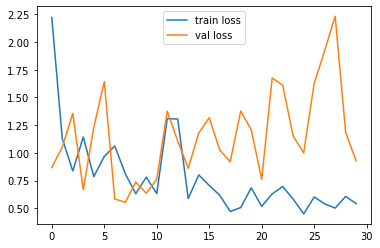

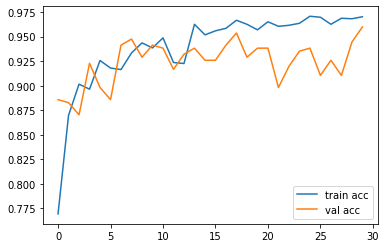

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
model = load_model(model_path)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________